# Loading the dataset

In [120]:
#import warnings
#warnings.filterwarnings('ignore')

In [121]:
%matplotlib inline 
import matplotlib
import itertools


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
raw_data = pd.read_csv('network_backup_dataset.csv')
# print(raw_data)
# print(raw_data.loc[0])
# print(raw_data.loc[1])

# Preprocess raw_data to data (numerical representation)
weekdays = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7}
data = np.zeros(raw_data.shape)
for i in range(raw_data.shape[0]):
    for j in range(raw_data.shape[1]):
        if j == 1: # Day of week
            data[i][j] = float(weekdays[raw_data.loc[i]['Day of Week']])
        elif j == 3: # workflow id
            data[i][j] = float(raw_data.loc[i]['Work-Flow-ID'].split('_')[-1])
        elif j == 4: # file name id
            data[i][j] = float(raw_data.loc[i]['File Name'].split('_')[-1])
        else:
            data[i][j] = float(raw_data.loc[i][j])

# print(data[0])

### a) For a twenty-day period (X-axis unit is day number) plot the backup sizes for all workflows (color coded on the Y-axis)

In [122]:
# raw_data.loc[(raw_data['Week #'] == 1) & (raw_data['Day of Week'] == 'Monday')]
# np.sum(data[(data[:,0] == 1) & (data[:,1] == 1) & (data[:,3] == 0)], axis=0)[5]

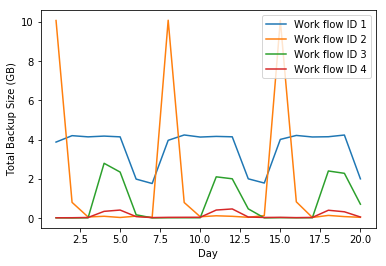

In [123]:
days = np.arange(1,21) # 20 day period
for wid in range(4): # 5 workflows
    sizes = []
    for d in days:
        week, week_day = ((int(d / 7) + 1, int(d % 7)) if int(d % 7) is not 0 else (int(d / 7), 7))
#         print(week, week_day)
        total_size = np.sum(data[(data[:,0] == week) & (data[:,1] == week_day) & (data[:,3] == wid)], axis=0)[5]
        sizes.append(total_size)
    plt.plot(days, sizes, label='Work flow ID %i' % (wid + 1))
    plt.xlabel('Day')
    plt.ylabel('Total Backup Size (GB)')
    plt.legend()

plt.show()

### b) Do the same plot for the first 105-day period. Can you identify any repeating patterns?

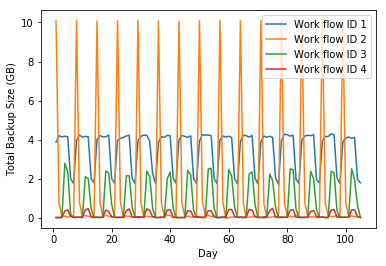

In [124]:
days = np.arange(1,106) # 20 day period
for wid in range(4): # 5 workflows
    sizes = []
    for d in days:
        week, week_day = ((int(d / 7) + 1, int(d % 7)) if int(d % 7) is not 0 else (int(d / 7), 7))
#         print(week, week_day)
        total_size = np.sum(data[(data[:,0] == week) & (data[:,1] == week_day) & (data[:,3] == wid)], axis=0)[5]
        sizes.append(total_size)
    plt.plot(days, sizes, label='Work flow ID %i' % (wid + 1))
    plt.xlabel('Day')
    plt.ylabel('Total Backup Size (GB)')
    plt.legend()

plt.show()
#5 categorical features: Day of the week, hour of the day, work-flow number, file-name, and week number

All the work flows have a very clear pattern of a spike in total backup size every week. For example, the work flow 2 consistently reaches a total backup size of 10G

# Prediction of backup size
## a) Linear Regression

### i) Use raw numerical encodings - Here, Monday through Sunday were mapped to 1 through 7, and the work-flow number and file-name were converted to its respective indices, i.e. the strings "work_flow_" and "File_" were removed. The results of fitting a linear model onto this dataset was as such:

Fold 1: train RMSE = 0.103, test RMSE = 0.107
Fold 2: train RMSE = 0.104, test RMSE = 0.100
Fold 3: train RMSE = 0.103, test RMSE = 0.107
Fold 4: train RMSE = 0.104, test RMSE = 0.100
Fold 5: train RMSE = 0.103, test RMSE = 0.107
Fold 6: train RMSE = 0.104, test RMSE = 0.100
Fold 7: train RMSE = 0.103, test RMSE = 0.107
Fold 8: train RMSE = 0.104, test RMSE = 0.100
Fold 9: train RMSE = 0.103, test RMSE = 0.107
Fold 10: train RMSE = 0.104, test RMSE = 0.100


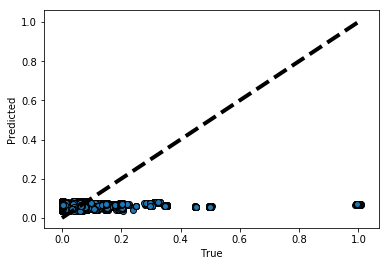

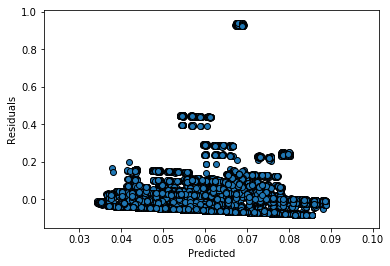

In [125]:
from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error
from math import sqrt

X = data[:,0:5]
y = data[:,5]

kf = KFold(10)
k = 1
lr = linear_model.LinearRegression()
for train_index, test_index in kf.split(X): # Output 10 train test RMSE values
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    lr.fit(X_train, y_train)
    pred_train, pred_test = lr.predict(X_train), lr.predict(X_test)
    
    rmse_train, rmse_test = sqrt(mean_squared_error(y_train, pred_train)), sqrt(mean_squared_error(y_test, pred_test))
    print("Fold %i: train RMSE = %.3f, test RMSE = %.3f" % (k, rmse_train, rmse_test))
    k += 1

lr = linear_model.LinearRegression()
predicted = cross_val_predict(lr, X, y, cv=10)

fig, ax = plt.subplots()
ax.scatter(y, predicted, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('True')
ax.set_ylabel('Predicted')
plt.show()

fig, ax = plt.subplots()
residuals = y - predicted
ax.scatter(predicted, residuals, edgecolors=(0, 0, 0))
ax.set_xlabel('Predicted')
ax.set_ylabel('Residuals')
plt.show()



The figure shows the naive model performs poorly for true backup sizes larger than 0.1 i.e. the model does not generalize well to the full range of backup sizes. However, from observing the second residual vs. predicted graph, the model can fit well for the true backup sizes less than 0.1, which constitutes most of the examples in the dataset. It is clear that the residuals for most examples are in between 0 and 0.2.

### ii) Here, we standardize numerical features to have zero mean and unit variance. The results are as such:

Fold 1: train RMSE = 0.103, test RMSE = 0.107
Fold 2: train RMSE = 0.104, test RMSE = 0.100
Fold 3: train RMSE = 0.103, test RMSE = 0.107
Fold 4: train RMSE = 0.104, test RMSE = 0.100
Fold 5: train RMSE = 0.103, test RMSE = 0.107
Fold 6: train RMSE = 0.104, test RMSE = 0.100
Fold 7: train RMSE = 0.103, test RMSE = 0.107
Fold 8: train RMSE = 0.104, test RMSE = 0.100
Fold 9: train RMSE = 0.103, test RMSE = 0.107
Fold 10: train RMSE = 0.104, test RMSE = 0.100


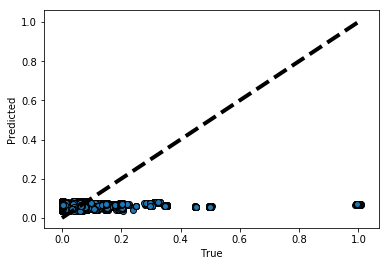

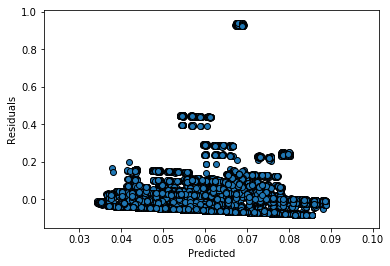

In [126]:
from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.preprocessing import StandardScaler

X = data[:,0:5]
y = data[:,5]
scaler = StandardScaler()
X = scaler.fit_transform(X, y)


kf = KFold(10)
k = 1
lr = linear_model.LinearRegression()
for train_index, test_index in kf.split(X): # Output 10 train test RMSE values
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    lr.fit(X_train, y_train)
    pred_train, pred_test = lr.predict(X_train), lr.predict(X_test)
    
    rmse_train, rmse_test = sqrt(mean_squared_error(y_train, pred_train)), sqrt(mean_squared_error(y_test, pred_test))
    print("Fold %i: train RMSE = %.3f, test RMSE = %.3f" % (k, rmse_train, rmse_test))
    k += 1

lr = linear_model.LinearRegression()
predicted = cross_val_predict(lr, X, y, cv=10)

fig, ax = plt.subplots()
ax.scatter(y, predicted, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('True')
ax.set_ylabel('Predicted')
plt.show()

fig, ax = plt.subplots()
residuals = y - predicted
ax.scatter(predicted, residuals, edgecolors=(0, 0, 0))
ax.set_xlabel('Predicted')
ax.set_ylabel('Residuals')
plt.show()



The standardization of features does not affect the regression performance as one can see from the graphs above (they stay highly similar to the those of (i)). Overall, the fitting result does not change.

### iii) We will now determine the three most important features that influence the backup size, using f regression and mutual information regression measure.

In [127]:
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
skb_f = SelectKBest(f_regression, k=3)
X_new_f = skb_f.fit_transform(X, y)
print("f_regression: " + str(skb_f.get_support()))
skb_m = SelectKBest(mutual_info_regression, k=3)
X_new_m = skb_m.fit_transform(X, y)
print("mutual_info_regression: " + str(skb_m.get_support()))

f_regression: [False  True  True  True False]
mutual_info_regression: [False False  True  True  True]


Hence, the three most important features determined using f_regression are day of week, hour of day, and the work flow id. Conversely, the three most important features determined using mutual info regression are hour of day, work flow id, and the file id. Now we will use only these three features for each regression technique to compare the model performance.

Fold 1: train RMSE = 0.103, test RMSE = 0.107
Fold 2: train RMSE = 0.104, test RMSE = 0.100
Fold 3: train RMSE = 0.103, test RMSE = 0.107
Fold 4: train RMSE = 0.104, test RMSE = 0.100
Fold 5: train RMSE = 0.103, test RMSE = 0.107
Fold 6: train RMSE = 0.104, test RMSE = 0.100
Fold 7: train RMSE = 0.103, test RMSE = 0.107
Fold 8: train RMSE = 0.104, test RMSE = 0.100
Fold 9: train RMSE = 0.103, test RMSE = 0.107
Fold 10: train RMSE = 0.104, test RMSE = 0.100


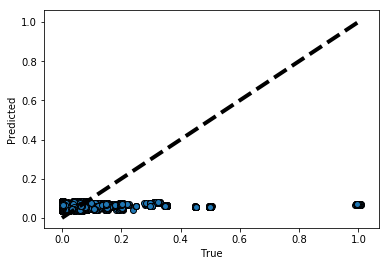

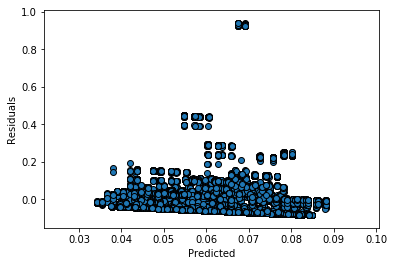

In [128]:
from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.preprocessing import StandardScaler

kf = KFold(10)
k = 1
lr = linear_model.LinearRegression()
for train_index, test_index in kf.split(X_new_f): # Output 10 train test RMSE values
    X_train, X_test = X_new_f[train_index], X_new_f[test_index]
    y_train, y_test = y[train_index], y[test_index]
    lr.fit(X_train, y_train)
    pred_train, pred_test = lr.predict(X_train), lr.predict(X_test)
    
    rmse_train, rmse_test = sqrt(mean_squared_error(y_train, pred_train)), sqrt(mean_squared_error(y_test, pred_test))
    print("Fold %i: train RMSE = %.3f, test RMSE = %.3f" % (k, rmse_train, rmse_test))
    k += 1

lr = linear_model.LinearRegression()
predicted = cross_val_predict(lr, X_new_f, y, cv=10)

fig, ax = plt.subplots()
ax.scatter(y, predicted, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('True')
ax.set_ylabel('Predicted')
plt.show()

fig, ax = plt.subplots()
residuals = y - predicted
ax.scatter(predicted, residuals, edgecolors=(0, 0, 0))
ax.set_xlabel('Predicted')
ax.set_ylabel('Residuals')
plt.show()



Using f regression, the model's performance is basically identical to those from (i) and (ii). This observation can be used as evidence to believe that the original linear model only weighs these three features to make the final prediction, essentially almost ignoring the other two features as they do not contribute as much.

Fold 1: train RMSE = 0.103, test RMSE = 0.107
Fold 2: train RMSE = 0.104, test RMSE = 0.100
Fold 3: train RMSE = 0.103, test RMSE = 0.107
Fold 4: train RMSE = 0.104, test RMSE = 0.100
Fold 5: train RMSE = 0.103, test RMSE = 0.107
Fold 6: train RMSE = 0.104, test RMSE = 0.100
Fold 7: train RMSE = 0.103, test RMSE = 0.107
Fold 8: train RMSE = 0.104, test RMSE = 0.100
Fold 9: train RMSE = 0.103, test RMSE = 0.107
Fold 10: train RMSE = 0.104, test RMSE = 0.100


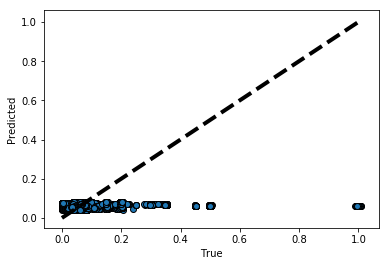

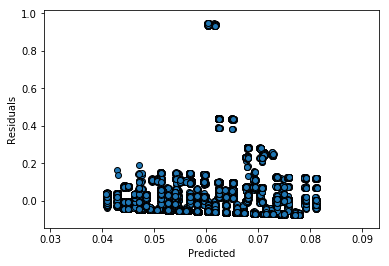

In [129]:
from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.preprocessing import StandardScaler

kf = KFold(10)
k = 1
lr = linear_model.LinearRegression()
for train_index, test_index in kf.split(X_new_m): # Output 10 train test RMSE values
    X_train, X_test = X_new_m[train_index], X_new_m[test_index]
    y_train, y_test = y[train_index], y[test_index]
    lr.fit(X_train, y_train)
    pred_train, pred_test = lr.predict(X_train), lr.predict(X_test)
    
    rmse_train, rmse_test = sqrt(mean_squared_error(y_train, pred_train)), sqrt(mean_squared_error(y_test, pred_test))
    print("Fold %i: train RMSE = %.3f, test RMSE = %.3f" % (k, rmse_train, rmse_test))
    k += 1

lr = linear_model.LinearRegression()
predicted = cross_val_predict(lr, X_new_m, y, cv=10)

fig, ax = plt.subplots()
ax.scatter(y, predicted, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('True')
ax.set_ylabel('Predicted')
plt.show()

fig, ax = plt.subplots()
residuals = y - predicted
ax.scatter(predicted, residuals, edgecolors=(0, 0, 0))
ax.set_xlabel('Predicted')
ax.set_ylabel('Residuals')
plt.show()



In the case of using mutual info regression, the two graphs above finally differs from the previous ones. The graphs indicate a decrease in regression performance as many residuals are now above 0, as there is no giant cluster of residuals ceneterd around 0.

### iv) Here, we utilize 32 feature encodings that encapsulate all the feature combinations generated from 5 features (2^5 = 32). 
Plot the average training RMSE and test RMSE for each combination (in range 1 to 32). Which combinations achieve best performance? Can you provide an intuitive explanation?


In [130]:
import itertools
from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

X = data[:,0:5]
y = data[:,5]
num_cols = 5
table = list(itertools.product([False, True], repeat=num_cols))
#print(table)
avg_training_rmse = []
avg_test_rmse = []
for c, combination in enumerate(table):
    print(str(c) + " " + str(combination))
    enc = OneHotEncoder(categorical_features=combination, sparse=False)
    X_new = enc.fit_transform(X)

    kf = KFold(10)
    k = 1
    
    training_rmse = []
    test_rmse = []
    for train_index, test_index in kf.split(X_new): # Output 10 train test RMSE values
        X_train, X_test = X_new[train_index], X_new[test_index]
        y_train, y_test = y[train_index], y[test_index]
        lr = linear_model.LinearRegression()
        lr.fit(X_train, y_train)
        pred_train, pred_test = lr.predict(X_train), lr.predict(X_test)

        rmse_train, rmse_test = sqrt(mean_squared_error(y_train, pred_train)), sqrt(mean_squared_error(y_test, pred_test))
        training_rmse.append(rmse_train)
        test_rmse.append(rmse_test)
#        print("Fold %i: train RMSE = %.3f, test RMSE = %.3f" % (k, rmse_train, rmse_test))
        k += 1
#     print(np.mean(training_rmse), np.mean(test_rmse))
    avg_training_rmse.append(np.mean(training_rmse))
    avg_test_rmse.append(np.mean(test_rmse))
    
print(np.argmin(avg_training_rmse), np.argmin(avg_test_rmse))
print(avg_training_rmse[14], avg_test_rmse[15])

0 (False, False, False, False, False)
1 (False, False, False, False, True)
2 (False, False, False, True, False)
3 (False, False, False, True, True)
4 (False, False, True, False, False)
5 (False, False, True, False, True)
6 (False, False, True, True, False)
7 (False, False, True, True, True)
8 (False, True, False, False, False)
9 (False, True, False, False, True)
10 (False, True, False, True, False)
11 (False, True, False, True, True)
12 (False, True, True, False, False)
13 (False, True, True, False, True)
14 (False, True, True, True, False)
15 (False, True, True, True, True)
16 (True, False, False, False, False)
17 (True, False, False, False, True)
18 (True, False, False, True, False)
19 (True, False, False, True, True)
20 (True, False, True, False, False)
21 (True, False, True, False, True)
22 (True, False, True, True, False)
23 (True, False, True, True, True)
24 (True, True, False, False, False)
25 (True, True, False, False, True)
26 (True, True, False, True, False)
27 (True, True, F

In [150]:
print(avg_training_rmse)

[0.103584726740266, 0.091335283872995318, 0.091337618816537514, 0.091336535960533191, 0.1023610128869286, 0.089947988889721747, 0.089948988898778795, 0.08994716816566016, 0.10215301123013258, 0.089755013062844752, 0.08975721358624969, 0.089753906860345276, 0.10090583818200208, 0.088336406323721972, 0.088338548760918151, 0.088336984595366236, 0.10357988004407148, 0.091331513556892452, 0.091333194681151503, 0.091335299827846578, 0.10235520077662819, 0.08994309794616373, 0.089944364095640592, 0.089954931408145561, 0.1021488896301858, 0.089751991743027337, 0.089753677798319276, 0.089752372566595337, 0.10093826794147769, 0.088342454535232276, 0.088336642350629505, 0.08840956668077006]


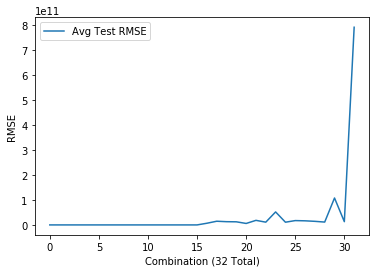

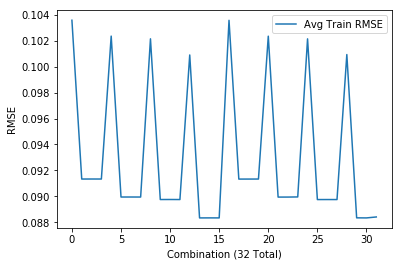

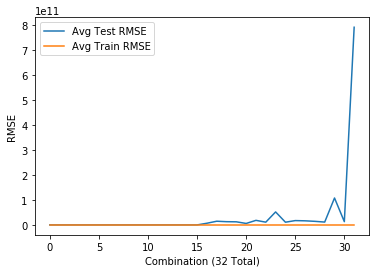

In [153]:
#Figure 1
fig, ax = plt.subplots()
#ax.scatter(y, predicted, edgecolors=(0, 0, 0))
ax.plot(avg_test_rmse, label="Avg Test RMSE")
#ax.plot(avg_training_rmse, label="Avg Train RMSE")
  
ax.set_xlabel('Combination (32 Total)')
ax.set_ylabel('RMSE')
plt.legend()
plt.show()

#Figure 2
fig, ax = plt.subplots()
#ax.scatter(y, predicted, edgecolors=(0, 0, 0))
ax.plot(avg_training_rmse, label="Avg Train RMSE")
ax.set_xlabel('Combination (32 Total)')
ax.set_ylabel('RMSE')
plt.legend()
plt.show()

#Figure 3
fig, ax = plt.subplots()
#ax.scatter(y, predicted, edgecolors=(0, 0, 0))
ax.plot(avg_test_rmse, label="Avg Test RMSE")
ax.plot(avg_training_rmse, label="Avg Train RMSE")
  
ax.set_xlabel('Combination (32 Total)')
ax.set_ylabel('RMSE')
plt.legend()
plt.show()



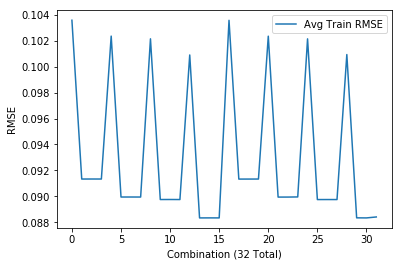

From the graph above, it is clear that for all combiations, the train RMSE stays consistently low around 0.08. However, the test RMSE shows the true predictive performance of each combination
Combination 16, (False, True, True, True, True), had the lowest test RMSE of 0.0884. In this combination, every feature, except the week #, was converted into a 1hot categorical representation. Intuitively, this makes sense as converting the week # into a 1hot representation is not reasonable as week # will continously increase since it is a timeseries feature (one would have to add one extra column for every single new week we observe). Every other feature, however, can clearly be converted into a 1hot representation as each feature is naturally categorical e.g. day of week and hour of day.

## b) Random Forest Regression
### i) Report training and average test RMSE from 10 fold cross validation, as well as out of bag error.

Fold 1: train RMSE = 0.060, test RMSE = 0.068
Fold 2: train RMSE = 0.061, test RMSE = 0.053
Fold 3: train RMSE = 0.060, test RMSE = 0.067
Fold 4: train RMSE = 0.060, test RMSE = 0.052
Fold 5: train RMSE = 0.060, test RMSE = 0.067
Fold 6: train RMSE = 0.062, test RMSE = 0.054
Fold 7: train RMSE = 0.060, test RMSE = 0.067
Fold 8: train RMSE = 0.060, test RMSE = 0.052
Fold 9: train RMSE = 0.060, test RMSE = 0.067
Fold 10: train RMSE = 0.061, test RMSE = 0.053
Out of bag error:  0.655900539425


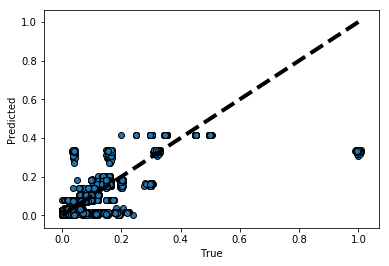

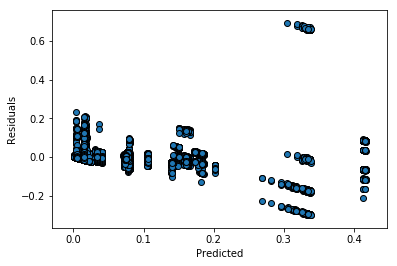

In [132]:
from sklearn.ensemble import RandomForestRegressor 

rf = RandomForestRegressor(n_estimators=20, max_features=5, max_depth=4, 
                           bootstrap=True, oob_score=False, n_jobs=-1)
kf = KFold(10)

k = 1
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    rf.fit(X_train, y_train)
    
    pred_train, pred_test = rf.predict(X_train), rf.predict(X_test)
    
    rmse_train = sqrt(mean_squared_error(y_train, pred_train))
    rmse_test = sqrt(mean_squared_error(y_test, pred_test))
    
    print("Fold %i: train RMSE = %.3f, test RMSE = %.3f" % (k, rmse_train, rmse_test))
    k += 1

rf = RandomForestRegressor(n_estimators=20, max_features=5, max_depth=4, 
                           bootstrap=True, n_jobs=-1)
predicted = cross_val_predict(rf, X, y, cv=10)

rf = RandomForestRegressor(n_estimators=20, max_features=5, max_depth=4, 
                           bootstrap=True, oob_score=True, n_jobs=-1)
rf.fit(X, y)
oob = rf.oob_score_
print("Out of bag error: ", oob)

fig, ax = plt.subplots()
ax.scatter(y, predicted, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('True')
ax.set_ylabel('Predicted')
plt.show()

fig, ax = plt.subplots()
residuals = y - predicted
ax.scatter(predicted, residuals, edgecolors=(0, 0, 0))
ax.set_xlabel('Predicted')
ax.set_ylabel('Residuals')
plt.show()




### ii) Sweep over number of trees from 1 to 200 and maximum number of features from 1 to 5. Plot out of bag error (y-axis) vs. number of trees (x-axis) as figure 1. Plot average test RMSE (y-axis) against number of trees (x axis).


In [133]:
import warnings
warnings.filterwarnings('ignore')

num_trees_min = 1
num_trees_max = 200
num_features_min = 1
num_features_max = 5

bag_errors = []
rmses = []
for num_features in range(num_features_min, num_features_max+1):
    bag_errors_for_cur_feature = []
    rmses_cur_feature = []
    for num_trees in range(num_trees_min, num_trees_max+1):
        rf = RandomForestRegressor(n_estimators=num_trees, max_features=num_features, max_depth=4, 
                           bootstrap=True, oob_score=True, n_jobs=-1)
        rf.fit(X_train, y_train)
        
        y_pred = rf.predict(X_test)
        bag_errors_for_cur_feature.append(1-rf.oob_score_)
        
        rmses_cur_feature.append(sqrt(mean_squared_error(y_test, y_pred)))
        
    rmses.append(rmses_cur_feature)
    bag_errors.append(bag_errors_for_cur_feature)

            

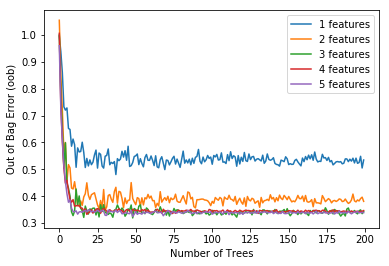

In [134]:
#Figure 1
fig, ax = plt.subplots()
#ax.scatter(y, predicted, edgecolors=(0, 0, 0))
#ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
i = 0
for oob in bag_errors:
    ax.plot(oob, label=str(i+1)+" features")
    i+=1
    
ax.set_xlabel('Number of Trees')
ax.set_ylabel('Out of Bag Error (oob)')
plt.legend()
plt.show()

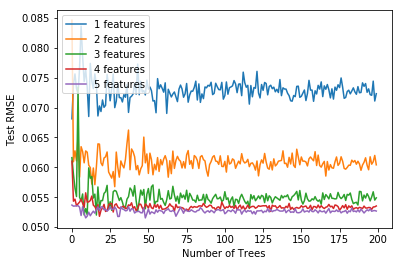

In [135]:
fig, ax = plt.subplots()

i=0
for rmse in rmses:
    ax.plot(rmse, label=str(i+1)+" features")
    i+=1
    
ax.set_xlabel('Number of Trees')
ax.set_ylabel('Test RMSE')
plt.legend()
plt.show()

### iii) Choose another parameter to tune
max_depth was chosen as another parameter to tune. Our hypothesis is that increasing this value too much will cause the random forest to overfit the data. This will be shown in the plots and is denoted by progressively worse and worse test errors. However, it's possible that test error may actually reduce up to a certain point, at which overfitting will cause it to increase.

In [136]:
import warnings
warnings.filterwarnings('ignore')

min_depth = 1
max_depth = 30

bag_errors = []
test_rmses = []
train_rmses = []
depths = np.linspace(1, max_depth, max_depth)

for depth in range(min_depth, max_depth+1):
    rf = RandomForestRegressor(n_estimators=20, max_features=5, max_depth=depth, 
                       bootstrap=True, oob_score=True, n_jobs=-1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_test)
    y_pred_train = rf.predict(X_train)
    bag_errors.append(1-rf.oob_score_)
    train_rmses.append(sqrt(mean_squared_error(y_train, y_pred_train)))
    test_rmses.append(sqrt(mean_squared_error(y_test, y_pred)))
            

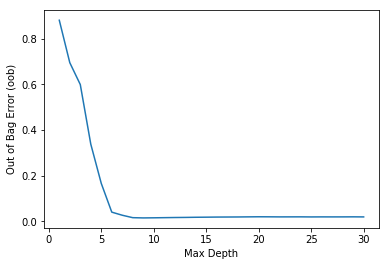

In [137]:
#Figure 1
fig, ax = plt.subplots()
#ax.scatter(y, predicted, edgecolors=(0, 0, 0))
#ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.plot(depths, bag_errors)
    
ax.set_xlabel('Max Depth')
ax.set_ylabel('Out of Bag Error (oob)')
plt.legend()
plt.show()

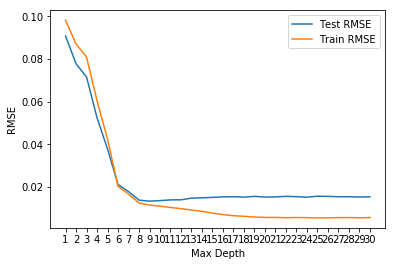

In [138]:
fig, ax = plt.subplots()

ax.plot(depths, test_rmses, label="Test RMSE")
ax.plot(depths, train_rmses, label="Train RMSE")    
ax.set_xticks(depths)
ax.set_xlabel('Max Depth')
ax.set_ylabel('RMSE')
plt.legend()
plt.show()

For this test, n_estimators was set to 20 and max_features to 5. This was because these values appeared to have good performance in the section above. The graphs for random forests with max_features=5 had the lowest out of bag error as well as test RMSE. With 5 features, there is also less variation with respect to the number of trees used in the ensemble.
<br><br>
By looking at the plot of OOB vs. max depth and Test RMSE vs. max depth, it's clear that adding more and more depth to the random forest causes overfitting. The plot showing both test RMSE and train RMSe vs. max depth can help us choose an optimal depth. Max depth of 8 appears ot be best for this data set. After 8, there is a spread between the test and train RMSE. This spread is characteristically overfitting, as indicated by test RMSE increasing while train RMSE is decreasing. 

### iv) Report the feature importances you got from the best random forest regression.
The plot below shows which features are the most informative and which are not. Clearly, feature 2 is the most informative, followed by features 4, 1, and 3. Feature 0 i sthe least informative. This graph would indicate that an optimal model in terms of efficiency and capacity would use features 1-4 but omit feature 0.

Feature ranking:
1. feature 2 (0.393313)
2. feature 4 (0.226199)
3. feature 1 (0.201544)
4. feature 3 (0.177781)
5. feature 0 (0.001162)


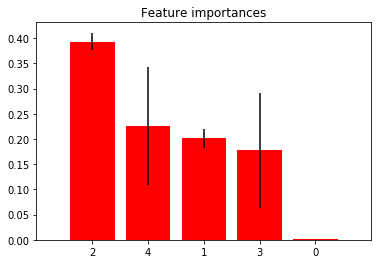

In [139]:
forest = RandomForestRegressor(n_estimators=20, max_features=5, max_depth=8, 
                   bootstrap=True, oob_score=True, n_jobs=-1)
forest.fit(X, y)
importances = forest.feature_importances_

std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

### v) Visualize your decision trees. Pick any tree (estimator) in best random forest (with max depth=4) and plot its structure, which is the root node in this decision tree? Is it the most important feature according to the feature importance reported by the regressor?

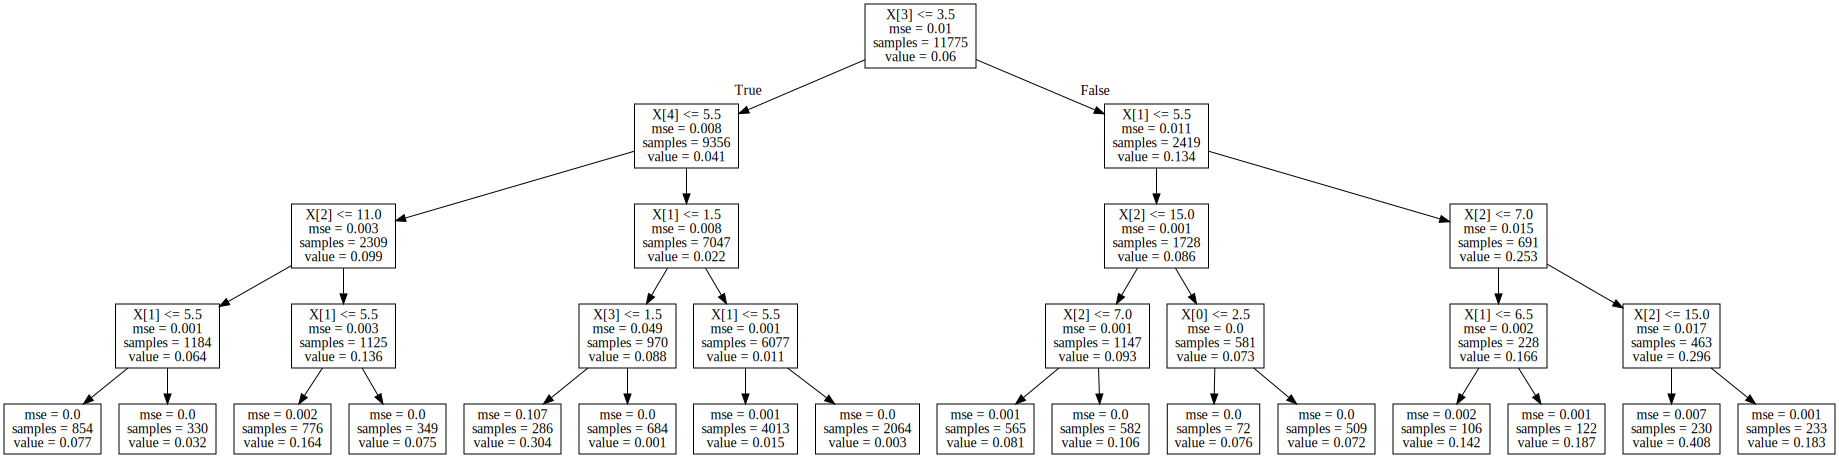

In [140]:
from sklearn.tree import export_graphviz
import graphviz

#export_graphviz()
forest = RandomForestRegressor(n_estimators=20, max_features=5, max_depth=4, 
                   bootstrap=True, oob_score=True, n_jobs=-1)
forest.fit(X, y)
estimator = forest.estimators_[0]

export_graphviz(estimator, out_file='tree.dot')
with open("tree.dot") as f:
    dot_graph = f.read()
    
graphviz.Source(dot_graph)

## c) Neural Network Regression

In [141]:
from sklearn.preprocessing import OneHotEncoder 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


enc = OneHotEncoder()
train_encoded = enc.fit_transform(X_train)
train_encoded_arr = train_encoded.toarray()

test_encoded = enc.transform(X_test)
test_encoded_arr = test_encoded.toarray()



In [142]:
print(train_encoded_arr.shape)
print(test_encoded_arr.shape)

(14870, 63)
(3718, 63)


In [143]:
from sklearn.neural_network import MLPRegressor


hidden_configs = [50, 100, 200, 300, 500]
activation_types = ['relu', 'logistic', 'tanh']

rmses = {}
for combo in list(itertools.product(activation_types,hidden_configs)):
    num_hidden = (combo[1] , )
    activation = combo[0]

    mlp = MLPRegressor(hidden_layer_sizes=num_hidden, activation=activation)
    mlp.fit(X_train, y_train)

    y_pred = mlp.predict(X_test)
    rmses[combo] = sqrt(mean_squared_error(y_test, y_pred))
    


In [144]:
print(rmses)

{('relu', 50): 0.11064898508419463, ('relu', 100): 0.09641300384235706, ('relu', 200): 0.08397890212888967, ('relu', 300): 0.08449944925022305, ('relu', 500): 0.08045935813642759, ('logistic', 50): 0.08398073189493192, ('logistic', 100): 0.0852557430975226, ('logistic', 200): 0.08570398190312069, ('logistic', 300): 0.09144211132642523, ('logistic', 500): 0.10574524641327127, ('tanh', 50): 0.08900361341634763, ('tanh', 100): 0.08169408506477559, ('tanh', 200): 0.08362005411454876, ('tanh', 300): 0.08026844958399099, ('tanh', 500): 0.07895283294301328}


In [145]:
relu_x = []
relu_y = []
logistic_x = []
logistic_y = []
tanh_x = []
tanh_y = []

for combo, rmse in rmses.items():
    activation = combo[0]
    if activation is 'relu':
        relu_x.append(combo[1])
        relu_y.append(rmse)
    elif activation is 'logistic':
        logistic_x.append(combo[1])
        logistic_y.append(rmse)
    elif activation is 'tanh':
        tanh_x.append(combo[1])
        tanh_y.append(rmse)
        

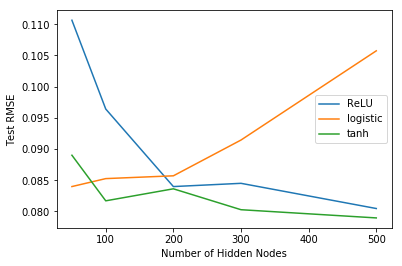

In [146]:
#plot RMSE (y-axis) vs. num hidden layers. This plot will have 3 curves, one for each activation type.
fig, ax = plt.subplots()

ax.plot(relu_x, relu_y, label='ReLU')
ax.plot(logistic_x, logistic_y, label='logistic')
ax.plot(tanh_x, tanh_y, label='tanh')
    
ax.set_xlabel('Number of Hidden Nodes')
ax.set_ylabel('Test RMSE')
plt.legend()
plt.show()

Several combinations were tested. Hidden layer possibilities included: 50, 100, 200, 300, and 1000. The activation types tested included ReLU, tanh, and logistic. From the graph above, it's clear that adding more nodes increases the expressive capacity of the network only when paired with certain activation functions. In general, the logistic activation function (sigmoid) suffers from a number of issues. Since sigmoid is not-zero centered, there can be zig-zagging gradients during gradient descent when the sign switches. In addition, at extreme values this saturates and has 0 gradient. On the plus side, around x=0 sigmoid behaves linearly and is differentiable everywhere. Tanh attempts to deal with some of these issues and is zero-centered. It shares the same benefits of sigmoid, but also saturates. ReLU has very simple derivatives and converges quickly. It can still experience zig-zagging gradients and the derivative is not defined at x=0, but we can use the subgradient. For examples with zero-activation, no learning will occur. One important point to mention is that ReLu is not bounded, but we can use weight regularization to deal with growing weights. 

The lowest Test RMSE was achieved for a network with 200 hidden nodes and a ReLU activation function. 

# d) Prediction of backup sizes for each workflows

In this section, we predicted the back up sizes for each individual workflows.

### i) Using linear regression model. Explain if the fit is improved?

We first utilized a simple linear regression model for predicting backup sizes for each workflow. For our preprocessing step, we normalize our data by centering the mean to 0 and setting the variance to 1. Afterwards, we apply a linear regression model using 10-fold cross validation. For each work flow, we plot the respective fitted values vs. true values, and the residuals vs. fitted values.

Work Flow 0
Fold 1: train RMSE = 0.036, test RMSE = 0.037
Fold 2: train RMSE = 0.036, test RMSE = 0.035
Fold 3: train RMSE = 0.036, test RMSE = 0.037
Fold 4: train RMSE = 0.036, test RMSE = 0.037
Fold 5: train RMSE = 0.036, test RMSE = 0.036
Fold 6: train RMSE = 0.036, test RMSE = 0.034
Fold 7: train RMSE = 0.036, test RMSE = 0.037
Fold 8: train RMSE = 0.036, test RMSE = 0.034
Fold 9: train RMSE = 0.036, test RMSE = 0.037
Fold 10: train RMSE = 0.036, test RMSE = 0.034


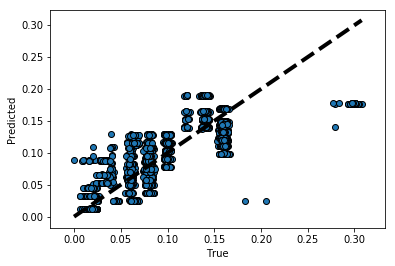

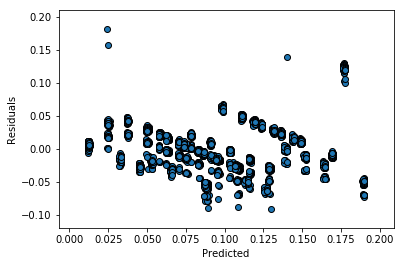

Work Flow 1
Fold 1: train RMSE = 0.146, test RMSE = 0.170
Fold 2: train RMSE = 0.151, test RMSE = 0.124
Fold 3: train RMSE = 0.146, test RMSE = 0.170
Fold 4: train RMSE = 0.151, test RMSE = 0.124
Fold 5: train RMSE = 0.146, test RMSE = 0.170
Fold 6: train RMSE = 0.151, test RMSE = 0.124
Fold 7: train RMSE = 0.146, test RMSE = 0.170
Fold 8: train RMSE = 0.151, test RMSE = 0.124
Fold 9: train RMSE = 0.146, test RMSE = 0.170
Fold 10: train RMSE = 0.151, test RMSE = 0.124


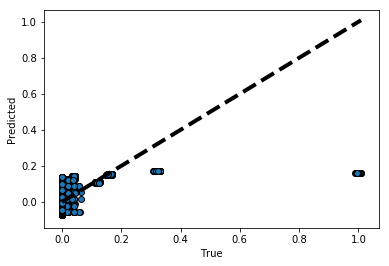

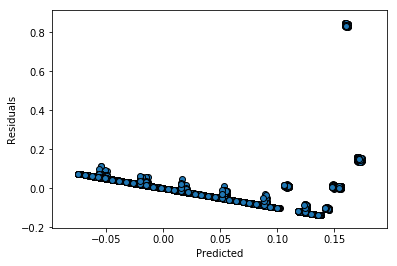

Work Flow 2
Fold 1: train RMSE = 0.044, test RMSE = 0.036
Fold 2: train RMSE = 0.042, test RMSE = 0.048
Fold 3: train RMSE = 0.044, test RMSE = 0.036
Fold 4: train RMSE = 0.042, test RMSE = 0.047
Fold 5: train RMSE = 0.044, test RMSE = 0.036
Fold 6: train RMSE = 0.042, test RMSE = 0.053
Fold 7: train RMSE = 0.043, test RMSE = 0.038
Fold 8: train RMSE = 0.042, test RMSE = 0.048
Fold 9: train RMSE = 0.044, test RMSE = 0.035
Fold 10: train RMSE = 0.042, test RMSE = 0.049


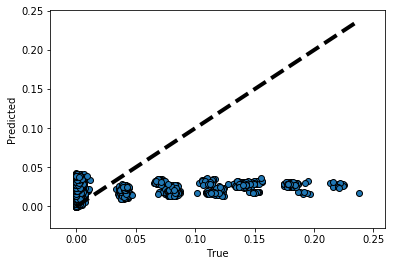

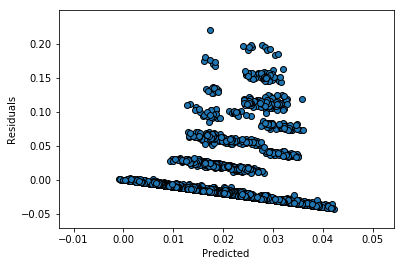

Work Flow 3
Fold 1: train RMSE = 0.007, test RMSE = 0.006
Fold 2: train RMSE = 0.007, test RMSE = 0.008
Fold 3: train RMSE = 0.007, test RMSE = 0.006
Fold 4: train RMSE = 0.007, test RMSE = 0.008
Fold 5: train RMSE = 0.007, test RMSE = 0.006
Fold 6: train RMSE = 0.007, test RMSE = 0.008
Fold 7: train RMSE = 0.007, test RMSE = 0.007
Fold 8: train RMSE = 0.007, test RMSE = 0.009
Fold 9: train RMSE = 0.007, test RMSE = 0.006
Fold 10: train RMSE = 0.007, test RMSE = 0.008


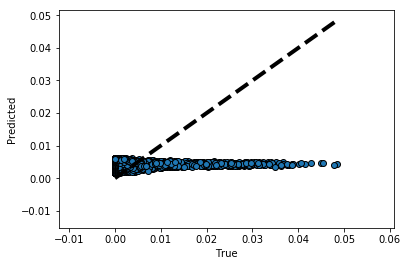

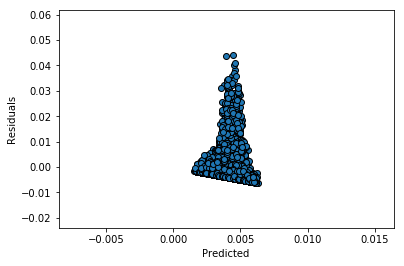

Work Flow 4
Fold 1: train RMSE = 0.087, test RMSE = 0.074
Fold 2: train RMSE = 0.085, test RMSE = 0.096
Fold 3: train RMSE = 0.087, test RMSE = 0.075
Fold 4: train RMSE = 0.085, test RMSE = 0.097
Fold 5: train RMSE = 0.087, test RMSE = 0.076
Fold 6: train RMSE = 0.085, test RMSE = 0.095
Fold 7: train RMSE = 0.087, test RMSE = 0.075
Fold 8: train RMSE = 0.085, test RMSE = 0.096
Fold 9: train RMSE = 0.087, test RMSE = 0.075
Fold 10: train RMSE = 0.085, test RMSE = 0.096


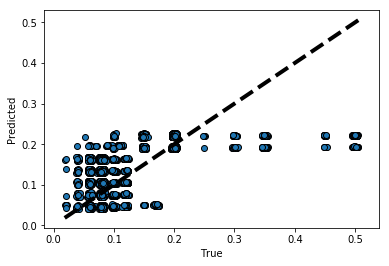

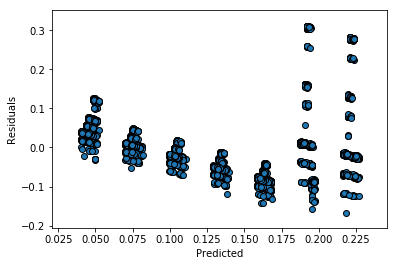

In [147]:
from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.preprocessing import StandardScaler

X = data[:,0:5]
y = data[:,5]

for wid in range(5):
    print("Work Flow %i" % wid)
    wid_data = data[(data[:,3] == wid)]
    X_wid = np.delete(wid_data[:,0:5], 3, axis=1)
    y_wid = wid_data[:,5]
    scaler = StandardScaler()
    X_wid = scaler.fit_transform(X_wid, y_wid)
    
    kf = KFold(10)
    k = 1
    lr = linear_model.LinearRegression()
    for train_index, test_index in kf.split(X_wid): # Output 10 train test RMSE values
        X_train, X_test = X_wid[train_index], X_wid[test_index]
        y_train, y_test = y_wid[train_index], y_wid[test_index]
        lr.fit(X_train, y_train)
        pred_train, pred_test = lr.predict(X_train), lr.predict(X_test)

        rmse_train, rmse_test = sqrt(mean_squared_error(y_train, pred_train)), sqrt(mean_squared_error(y_test, pred_test))
        print("Fold %i: train RMSE = %.3f, test RMSE = %.3f" % (k, rmse_train, rmse_test))
        k += 1
    
    lr = linear_model.LinearRegression()
    predicted = cross_val_predict(lr, X_wid, y_wid, cv=10)

    fig, ax = plt.subplots()
    ax.scatter(y_wid, predicted, edgecolors=(0, 0, 0))
    ax.plot([y_wid.min(), y_wid.max()], [y_wid.min(), y_wid.max()], 'k--', lw=4)
    ax.set_xlabel('True')
    ax.set_ylabel('Predicted')
    plt.show()

    fig, ax = plt.subplots()
    residuals = y_wid - predicted
    ax.scatter(predicted, residuals, edgecolors=(0, 0, 0))
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Residuals')
    plt.show()





Predicting each work flow separately does increase the predictive performance for most of the workflows. For Work Flows {0,2,3,4}, the models shows consistently lower RMSEs compared to our original linear model from part (a).

### ii) Try fitting a more complex regression function to your data. You can try a polynomial function of your variables. Try increasing the degree of the polynomial to improve your fit. Again, use a 10 fold cross validation to evaluate your results. Plot the average train and test RMSE of the trained model against the degree of the polynomial you use. Can you find a threshold on the degree of the fitted polynomial beyond which the generalization error of your model gets worse? Can you explain how cross-validation helps controlling the complexity of your model?

To improve our fit even further, we now applied more complex regression techniques by building polynomial functions with our original features. For example, if an input sample is two dimensional and of the form [x, y], the degree-2 polynomial features are [1, x, y, x^2, y^2, xy]. Adding model complexity allows the model to be more expressive. In theory, a model of arbitrarily high polynomial degree can only achieve better test performance than a model of lower degree on the same data. This is because the more complex model is a superset of the simpler model. We can reduce the more complex model to the simpler one by zeroing out certain parameters. 

The downside is overfitting. Overfitting for linear regression models generally occurs when higher order polynomials are added to the model. Adding higher order polynomials allows the learning algorithm to best fit the training data, but at the expense of complexity. Our inductive bias is such that simpler models are better, and from that we get the idea that we should keep weights minimal. The easiest way to keep weights as small as possible is by penalizing large weights through regularization. 


For our analysis, we increased the degree of the polynomial and plotted the average train and test RMSEs against the degrees.

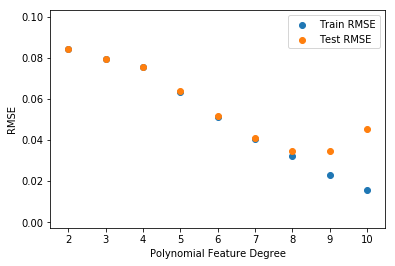

In [148]:
from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

X = data[:,0:5]
y = data[:,5]

degrees = range(2, 11)
avgTrainRMSEs, avgTestRMSEs = [], []
for p in degrees:
    X_p = PolynomialFeatures(p).fit_transform(X)
    y_p = y
    
    scaler = StandardScaler()
    X_p = scaler.fit_transform(X_p, y_p)
    
    kf = KFold(10)
    totalTrainRMSE, totalTestRMSE = 0, 0
    for train_index, test_index in kf.split(X_p): # Output 10 train test RMSE values
        X_train, X_test = X_p[train_index], X_p[test_index]
        y_train, y_test = y_p[train_index], y_p[test_index]
        lr = linear_model.LinearRegression()
        lr.fit(X_train, y_train)
        pred_train, pred_test = lr.predict(X_train), lr.predict(X_test)

        rmse_train, rmse_test = sqrt(mean_squared_error(y_train, pred_train)), sqrt(mean_squared_error(y_test, pred_test))
        totalTrainRMSE += rmse_train
        totalTestRMSE += rmse_test
    avgTrainRMSEs.append(totalTrainRMSE / 10)
    avgTestRMSEs.append(totalTestRMSE / 10)
    
fig, ax = plt.subplots()
ax.scatter(degrees, avgTrainRMSEs, label="Train RMSE")
ax.scatter(degrees, avgTestRMSEs, label="Test RMSE")    
ax.set_xticks(degrees)
ax.set_xlabel('Polynomial Feature Degree')
ax.set_ylabel('RMSE')
plt.legend()
plt.show()

The threshold to which the generalization performance suffers is when degree = 8, as clearly the train RMSE is comparatively lower than the test RMSE. 

Cross validation is generally used to measure the performance of a prediction model. Setting the polynomial degree of freedom to higher numbers can result in overfitting. Thus, cross validation helps us to acheive the best fit without overfitting on the data.

### e) Use k-nearest neighbor regression and find the best parameter.
Our aim here is to find the optimal k for kNN. Smallest values of k will cause overfitting. Large values of k will have a smoothing or averaging effect. A balance is in the middle, where the smoothing is not too excessive. Too much smoothing results in underfitting and performance will decrease.

In [149]:
from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.preprocessing import StandardScaler

X = data[:,0:5]
y = data[:,5]

for nn in range(2,7):
    print("%i neighbors" % nn)
    kf = KFold(10)
    k = 1
    neigh = KNeighborsRegressor(n_neighbors=nn)
    totalTrainRMSE, totalTestRMSE = 0, 0
    for train_index, test_index in kf.split(X): # Output 10 train test RMSE values
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        neigh.fit(X_train, y_train)
        pred_train, pred_test = neigh.predict(X_train), neigh.predict(X_test)

        rmse_train, rmse_test = sqrt(mean_squared_error(y_train, pred_train)), sqrt(mean_squared_error(y_test, pred_test))
        totalTrainRMSE += rmse_train
        totalTestRMSE += rmse_test
    print("\tavg train rmse = %.3f, avg test rmse = %.3f" % (totalTrainRMSE / 10, totalTestRMSE / 10))

#     neigh = KNeighborsRegressor(n_neighbors=2)
#     predicted = cross_val_predict(neigh, X, y, cv=10)

#     fig, ax = plt.subplots()
#     ax.scatter(y, predicted, edgecolors=(0, 0, 0))
#     ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
#     ax.set_xlabel('True')
#     ax.set_ylabel('Predicted')
#     plt.show()

#     fig, ax = plt.subplots()
#     residuals = y - predicted
#     ax.scatter(predicted, residuals, edgecolors=(0, 0, 0))
#     ax.set_xlabel('Predicted')
#     ax.set_ylabel('Residuals')
#     plt.show()





2 neighbors
	avg train rmse = 0.029, avg test rmse = 0.033
3 neighbors
	avg train rmse = 0.030, avg test rmse = 0.036
4 neighbors
	avg train rmse = 0.028, avg test rmse = 0.037
5 neighbors
	avg train rmse = 0.027, avg test rmse = 0.043
6 neighbors
	avg train rmse = 0.028, avg test rmse = 0.047


It is clear that setting number of neighbors, or k, to 2 is the most optimal parameter that yields the lowset test RMSE and best generalization performance. 

# Analysis
Overall, the best performing model was the Random Forest Regression model with max_depth = 8 as the test RMSE was 0.0143. The